## Import and preprocess datasets

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.ensemble.forest import RandomForestRegressor, RandomForestClassifier
import os
from sklearn import preprocessing, metrics
from importlib import reload
import sknn.mlp
from sklearn import tree  #for graphing random forest tree
import pickle
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 6)
inline_rc = dict(mpl.rcParams)
import src.nnload as nnload
import src.nntrain as nntrain
import src.nnplot as nnplot
# Set script parameters
minlev = 0.25
rainonly = False
write_nn_to_netcdf = False
fig_dir = './figs/'
data_dir = './data/'

/Users/jgdwyer/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/jgdwyer/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [29]:
reload(nnload)
x, y, cv, Pout, lat, lev, dlev, timestep = nnload.loaddata('./data/convection_50day.pkl', 
                            minlev, all_lats=True, indlat=None, rainonly=False, noshallow=True)

(50, 640)
(30, 64, 500)
(50, 640)
(16000, 15)
(32000,)
hey
(16000,)
There is some amount of rain 80.1% of the time
There is a rate of >3 mm/day 79.9% of the time
(16000, 30)
(16000,)
There is convection 84.1% of the time
(16000,)
Excluding all shallow convective events
There is convection 83.4% of the time


In [12]:
reload(nnload)
print(y.shape)
cv,_= nnload.whenconvection(y)
print(cv.shape)
print(Pout.shape)

(16000, 30)
(16000,)
There is convection 84.1% of the time
(16000,)
(32000,)


In [ ]:
plt.hist(Pout*3600*24+1,500)

In [2]:
x, y, cv, Pout, lat, lev, dlev, timestep = nnload.loaddata(data_dir + 'convection_50day.pkl', minlev,
                                                       rainonly=rainonly) #,all_lats=False,indlat=8)
#

There is some amount of rain 60.2% of the time
There is a rate of >3 mm/day 20.8% of the time
There is convection 84.1% of the time


In [63]:
# x_ppi={'name':'StandardScaler','method':'qTindividually'}
# x_pp = nnload.init_pp(y_ppi, y)
# y_ppi={'name':'MaxAbs','method':'qTindividually'}
# y_pp = nnload.init_pp(y_ppi, y)
# y2    = nnload.transform_data(y_ppi, y_pp, y)

xraw, y, cv, Pout, lat, lev, dlev, timestep = nnload.loaddata('./data/convection_50day.pkl', 
                            0.25, all_lats=False, indlat=6, rainonly=False)
r_str_eval = 'X-StandardScaler-qTindi_Y-MaxAbs-qTindi_r_200R_200R_200R_200R_mom0.9reg1e-05_w2'
r_mlp_eval, _, _, x_ppi, y_ppi, x_pp, y_pp, lat, lev, dlev = pickle.load(open(data_dir + 'regressors/' + r_str_eval + '.pkl', 'rb'))

x1 = nnload.transform_data(x_ppi,x_pp,xraw)
out_test = r_mlp_eval.predict(x1)
# out_test = out_test*y_pp.max_abs_
out_test = nnload.inverse_transform_data(y_ppi,y_pp,out_test)




# plt.figure()
# plt.plot(nnload.unpack(x,'T')[45,:],lev)
# plt.figure()
# plt.plot(nnload.unpack(x,'q')[45,:],lev)

# plt.figure()
# plt.plot(np.max(nnload.unpack(y/15,'T'),axis=0),lev)
# plt.plot(np.max(nnload.unpack(y/10,'q'),axis=0),lev)

# plt.plot(np.min(nnload.unpack(y/15,'T'),axis=0),lev,color='blue')
# plt.plot(np.min(nnload.unpack(y/10,'q'),axis=0),lev,color='green')

# plt.plot(np.mean(nnload.unpack(y/15,'T'),axis=0),lev,color='blue',ls='--')
# plt.plot(np.mean(nnload.unpack(y/10,'q'),axis=0),lev,color='green',ls='--')

There is some amount of rain 75.6% of the time
There is a rate of >3 mm/day 3.3% of the time
There is convection 59.0% of the time


/Users/jgdwyer/anaconda/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version pre-0.18 when using version 0.18. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/jgdwyer/anaconda/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator MaxAbsScaler from version pre-0.18 when using version 0.18. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/jgdwyer/anaconda/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


/Users/jgdwyer/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


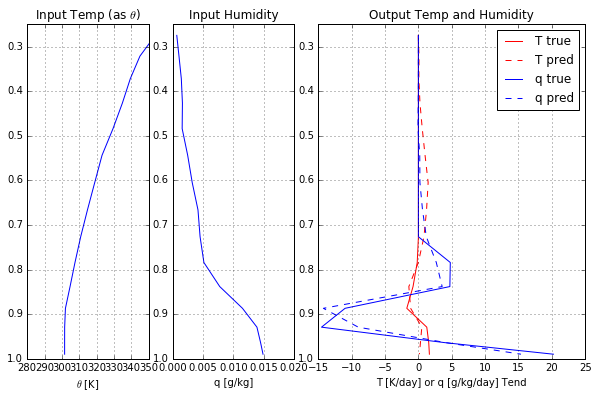

In [150]:
reload(nnplot)
exnum=np.random.randint(0,500);
nnplot.plot_sample_profiles(xraw[exnum,:], y[exnum,:], out_test[exnum,:], lev)

In [153]:
str(5)

'5'

In [44]:
# Load data
reload(nnload)
x, y, cv, Pout, lat, lev, dlev, timestep = nnload.loaddata(data_dir + 'convection_50day.pkl', minlev,
                                                       rainonly=rainonly) #,all_lats=False,indlat=8)
# Sample data, so we are not processing it all together

# Scale input data using transformation
x_ppi={'name':'StandardScaler','method':'individually'}
x_pp = nnload.init_pp(x_ppi, x)
x    = nnload.transform_data(x_ppi, x_pp, x)

# Scale output data using transformation
y_ppi={'name':'MaxAbs','method':'qTindividually'}
y_pp = nnload.init_pp(y_ppi, y)
y    = nnload.transform_data(y_ppi, y_pp, y)

# Make preprocessor string for saving
pp_str =          'X-' + x_ppi['name'] + '-' + x_ppi['method'][:6] + '_'
pp_str = pp_str + 'Y-' + y_ppi['name'] + '-' + y_ppi['method'][:6] + '_'

# Subsample data
x1, x2, x3, y1, y2, y3 = nnload.subsample(x, y, N_samples=10000)

There is some amount of rain 60.2% of the time
There is a rate of >3 mm/day 20.8% of the time
There is convection 84.1% of the time


In [ ]:

pp_str='new'
from importlib import reload
reload(nntrain)
batch_size = 100
r_mlp, r_str                  = nntrain.build_nn('regress',['Rectifier'],[399],'momentum', pp_str, batch_size,n_stable=75)
                                                # n_stable=25)#, regularize = 'L2', weight_decay = 0.0001)
print(r_str)
r_mlp, r_errors = nntrain.train_nn(r_mlp,r_str,x1,y1,x2,y2)



In [ ]:
yt_scl= y2
yt_unscl = ypp.inverse_transform(pcay.inverse_transform(y2))
yp_scl = r_mlp.predict(x2)
yp_unscl = ypp.inverse_transform(pcay.inverse_transform(yp_scl))

nnplot.check_output_distribution(yt_unscl, yt_scl, yp_unscl, yp_scl, lat, lev, '../')

## Create, train, evaluate, and store regressors NN's

In [ ]:
# Build, train, and save model
from importlib import reload
reload(nntrain)
batch_size = 100
r_mlp, r_str                  = nntrain.build_nn('regress',['Rectifier'],[400],'momentum', pp_str, batch_size,n_iter=25)
                                                # n_stable=25)#, regularize = 'L2', weight_decay = 0.0001)
print(r_str)
r_mlp, r_errors = nntrain.train_nn(r_mlp,r_str,x1,y1,x2,y2)
pickle.dump([r_mlp, r_str, r_errors, x_ppi, y_ppi, x_pp, y_pp, lat, lev, dlev],  open(data_dir + 'regressors/' + r_str + '_v2.pkl', 'wb'))

# Save model in netcdf format if requested
if write_nn_to_netcdf:
    nnload.write_netcdf_twolayer(r_mlp, 'regress', datadir + 'netcdf_models/' + r_str + '_neural_weights_regressor.nc')

## Compare all NNs to each other

In [ ]:
# Initialize regressors
reload(nntrain)
reload(nnplot)
#trained_regressors = ['r_600R_mom0.9reg0.0001','r_600R_mom0.9',
#                      'r_1200R_mom0.9','r_2400R_mom0.9','r_3600R_mom0.9',
#                      'r_4800R_mom0.9',
trained_regressors =  ['X-MinMax-alltog_Y-MaxAbs-alltog_r_400R_mom0.9',
 'X-MinMax-alltog_Y-MaxAbs-indivi_r_400R_mom0.9',
 'X-MinMax-alltog_Y-StandardScaler-alltog_r_400R_mom0.9',
 'X-MinMax-alltog_Y-StandardScaler-indivi_r_400R_mom0.9',
 'X-MinMax-indivi_Y-MaxAbs-alltog_r_400R_mom0.9',
 'X-MinMax-indivi_Y-MaxAbs-indivi_r_400R_mom0.9',
 'X-MinMax-indivi_Y-StandardScaler-alltog_r_400R_mom0.9',
 'X-MinMax-indivi_Y-StandardScaler-indivi_r_400R_mom0.9',
 'X-StandardScaler-alltog_Y-MaxAbs-alltog_r_400R_mom0.9',
 'X-StandardScaler-alltog_Y-MaxAbs-indivi_r_400R_mom0.9',
 'X-StandardScaler-alltog_Y-StandardScaler-alltog_r_400R_mom0.9',
 'X-StandardScaler-alltog_Y-StandardScaler-indivi_r_400R_mom0.9',
 'X-StandardScaler-indivi_Y-MaxAbs-alltog_r_400R_mom0.9',
 'X-StandardScaler-indivi_Y-MaxAbs-indivi_r_400R_mom0.9',
 'X-StandardScaler-indivi_Y-StandardScaler-alltog_r_400R_mom0.9',
 'X-StandardScaler-indivi_Y-StandardScaler-indivi_r_400R_mom0.9']


N_r = len(trained_regressors)
r_mlp = [0]*N_r
r_str = [0]*N_r
r_errors=np.empty((300000,4,N_r))
r_errors[:]=np.NAN

# Load regressors
for i,r in enumerate(trained_regressors):
    r_mlp[i], r_str[i], err, _,_,_,_,_,_,_ = pickle.load(open(data_dir + 'regressors/' + r + '.pkl', 'rb'))
    print(len(err))
    r_errors[:len(err),:,i]      =  err
# Compare them and plot output
nntrain.plot_regressors_scores(r_mlp,r_str,x2,y2,fig_dir + 'compare/','r')


In [64]:
reload(nnplot)
reload(nnload)
r_str='X-StandardScaler-indivi_Y-MaxAbs-qTindi_r_400R_mom0.9'
nnplot.plot_all_figs(r_str, xs, ys)
#nnplot.plot_model_error_over_time(np.squeeze(r_errors[:,:,0]), r_str[0], fig_dir + 'compare/','r')

/Users/jgdwyer/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


NameError: name 'xs' is not defined

## Plot test data evaluations

In [ ]:
# Load the model we want to do a detailed evaulation for
reload(nnplot)
reload(nnload)
r_str_eval = 'Stndrd_pca10_r_400R_mom0.9'
#r_mlp_eval, _, _, x_ppi, y_ppi, x_pp, y_pp, lat, lev, dlev = pickle.load(open(data_dir + 'regressors/' + r_str_eval + '.pkl', 'rb'))

# Set figure path and create directory if it does not exist
figpath = fig_dir + r_str_eval + '/'
if not os.path.exists(figpath):
    os.makedirs(figpath)

# Inverse transform output back to physical units
#y3_true = nnload.inverse_transform_data(y_ppi, y_pp, y2)
#y3_pred = nnload.inverse_transform_data(y_ppi, y_pp, r_mlp_eval.predict(x2))
#yt_scl= y2
y3_true = ypp.inverse_transform(pcay.inverse_transform(y2))
yp_scl = r_mlp.predict(x2)
y3_pred = ypp.inverse_transform(pcay.inverse_transform(yp_scl))


# Plot means and standard deviations
nnplot.plot_means_stds(y3_true, y3_pred, lev, figpath)

# Plot correlation coefficient, explained variance, and rmse
nnplot.plot_error_stats(y3_true, y3_pred, lev, figpath)

# Plot a time series of precipitaiton
nnplot.plot_precip(y3_true, y3_pred, dlev, figpath)

# Plot the enthalpy conservation
nnplot.plot_enthalpy(y3_true, y3_pred, dlev, figpath)

# Plot mean, bias, rmse, r^  (lat vs lev)
nnplot.make_contour_plots(figpath, x_ppi, y_ppi, x_pp, y_pp, r_mlp_eval, lat, lev)

# Plot the rmse vs lat
#nnplot.plot_rmse_vs_lat(r_mlp_eval, figpath, data_dir='./data/',minlev=0.0,rainonly=False)

## Check that I am interpreting algorithm correctly

In [28]:
reload(nnload)
xraw, y, cv, Pout, lat, lev, dlev, timestep = nnload.loaddata('./data/convection_50day.pkl', 
                            0.25, all_lats=True, indlat=None, rainonly=False)
r_str_eval = 'X-StandardScaler-qTindi_Y-MaxAbs-qTindi_r_300R_mom0.8reg0.0001_w2'
r_mlp_eval, _, _, x_ppi, y_ppi, x_pp, y_pp, lat, lev, dlev = pickle.load(open(data_dir + 'regressors/' + r_str_eval + '.pkl', 'rb'))
_ = r_mlp_eval.predict(x1[0:1,:])

nnload.write_netcdf_onelayer(r_mlp_eval, x_pp, y_pp)

There is some amount of rain 60.2% of the time
There is a rate of >3 mm/day 20.8% of the time
There is convection 84.1% of the time


In [71]:
reload(nnload)
r_str_eval='X-StandardScaler-qTindi_Y-SimpleY-qTindi_r_60R_60R_mom0.9reg1e-05'
r_mlp_eval, _, _, x_ppi, y_ppi, x_pp, y_pp, lat, lev, dlev = pickle.load(open(data_dir + 'regressors/' + r_str_eval + '.pkl', 'rb'))
_ = r_mlp_eval.predict(x1[0:1,:])
nnload.write_netcdf_onelayer(r_mlp_eval, x_pp, y_pp, filename='/Users/jgdwyer/neural_weights_v3.nc')

There is some amount of rain 60.2% of the time
There is a rate of >3 mm/day 20.8% of the time
There is convection 84.1% of the time
(16000, 30)


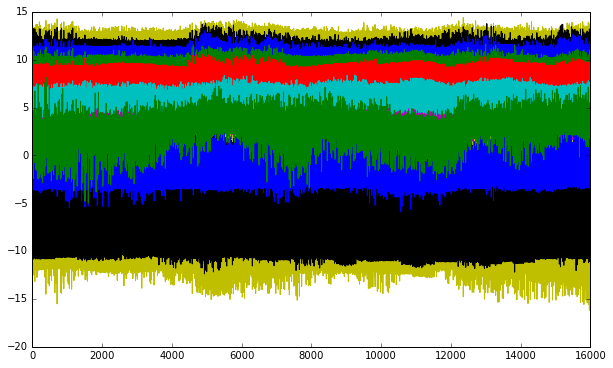

In [22]:
reload(nnload)
xraw, y, cv, Pout, lat, lev, dlev, timestep = nnload.loaddata('./data/convection_50day.pkl', 
                            0.25, all_lats=True, indlat=None, rainonly=False)
r_str_eval = 'X-StandardScaler-qTindi_Y-MaxAbs-qTindi_r_300R_mom0.8reg0.0001_w2'
r_mlp_eval, _, _, x_ppi, y_ppi, x_pp, y_pp, lat, lev, dlev = pickle.load(open(data_dir + 'regressors/' + r_str_eval + '.pkl', 'rb'))

x1 = nnload.transform_data(x_ppi,x_pp,xraw)
x2 = (xraw - x_pp.mean_)/x_pp.scale_
#xT=nnload.unpack(xraw,'T')
#xq=nnload.unpack(xraw,'q')
#xT = (xT - x_pp[0].mean_)/x_pp[0].scale_
#xq = (xq - x_pp[1].mean_)/x_pp[1].scale_
#x2 = nnload.pack(xT,xq)
print(x1.shape)
out_test = r_mlp_eval.predict(x1)
out_test = out_test*y_pp.max_abs_

w1 = r_mlp_eval.get_parameters()[0].weights
w2 = r_mlp_eval.get_parameters()[1].weights
b1 = r_mlp_eval.get_parameters()[0].biases
b2 = r_mlp_eval.get_parameters()[1].biases

out_test_check = np.dot(x2,w1) + b1
out_test_check[out_test_check<0] = 0
out_test_check = np.dot(out_test_check,w2) + b2

out_test_check = out_test_check*y_pp.max_abs_
plt.plot(out_test[:,:]-out_test_check[:,:])
plt.show()

In [ ]:
x_pp[1].scale_

In [ ]:


out_test = 
out_test = scaler_y.inverse_transform(out_test)
w1 = r_mlp.get_parameters()[0].weights
w2 = r_mlp.get_parameters()[1].weights
w3 = r_mlp.get_parameters()[2].weights
b1 = r_mlp.get_parameters()[0].biases
b2 = r_mlp.get_parameters()[1].biases
b3 = r_mlp.get_parameters()[2].biases

xscale_min = scaler_x.data_min_
xscale_max = scaler_x.data_max_
yscale_absmax = scaler_y.max_abs_

out_test_check = np.dot(x3,w1) + b1
out_test_check[out_test_check<0] = 0
out_test_check = np.dot(out_test_check,w2) + b2
out_test_check[out_test_check<0] = 0
out_test_check = np.dot(out_test_check,w3) + b3

out_test_check = out_test_check*yscale_absmax
ptl.plot(out_test-out_test_check)
plt.show()

In [ ]:
#module load python
#module load all-python-libs

import numpy as np
from netCDF4 import Dataset

# These are the number of samples (lon x time pairs) to take 
# for each 24-hour period at each latitude
N_samples = 10
first_day = 1001
last_day  = 1051 #not inclusive
N_days = last_day - first_day

# Hardcoded N_lev and N_lat here
Tin  = np.zeros(30,64,N_days,N_samples)
qin  = np.zeros(30,64,N_days,N_samples)
Tout = np.zeros(30,64,N_days,N_samples)
qout = np.zeros(30,64,N_days,N_samples)

# Loop over files (stats stored daily)
for i in range(first_day,last_day):
    filename='/glade/u/home/jdwyer/scratch/fms_output/' + \
             'del1.2_abs1.0_T42_30min/history/day' + \
              str(i).zfill(4) + 'h00/day' + \
              str(i).zfill(4) + 'h00.timestep.nc'
    print(filename)
    f = Dataset(filename,mode='r')
    zTin = f.variables['temp'][:] # N_time x N_lev x N_lat x N_lon
    zqin = f.variables['sphum'][:]
    zTout= f.variables['dt_tg_convection'][:]
    zqout= f.variables['dt_qg_convection'][:]
    #Pout= f.variables['convection_rain'][:] # N_time x N_lat x N_lon
    lat = f.variables['lat'][:]
    f.close()
    # The part of the timestep in the model when these fields are saved is different
    # Shift them so that input happens BEFORE output
    zTin = zTin[1:,:,:,:]
    zqin = zqin[1:,:,:,:]
    zTout = zTout[0:-1,:,:,:]
    zqout = zqout[0:-1,:,:,:]
    # Convert heating rates from K/s to K/day and from kg/kg/s to g/kg/day
    zTout = zTout*3600*24
    zqout = zqout*3600*24*1000
    #Now loop over each latitude and choose selections at random
    for j,_ in enumerate(lat):
        ind_time = np.random.randint(0,Tin.shape[0],10)
        ind_lon  = np.random.randint(0,Tin.shape[3],10)
        count = 0
        for k,_ in enumerate(ind_time):
            Tin[:,j,i,count]  = zTin[ind_time,:,j,ind_lon] # N_lev x N_lat x N_days x N_samp
            qin[:,j,i,count]  = zqin[ind_time,:,j,ind_lon]
            Tout[:,j,i,count] = zTout[ind_time,:,j,ind_lon]
            qout[:,j,i,count] = zqout[ind_time,:,j,ind_lon]
            count += 1
        
# Reshape array to be N_lev x N_lat x N_days*N_samp
Tin  = np.reshape(Tin ,(Tin.shape[0] ,Tin.shape[1] ,-1))
qin  = np.reshape(qin ,(qin.shape[0] ,qin.shape[1] ,-1))
Tout = np.reshape(Tout,(Tout.shape[0],Tout.shape[1],-1))
qout = np.reshape(qout,(qout.shape[0],qout.shape[1],-1))

# Store the files
pickle.dump([Tin, qin, Tout, qout, lat],  open('./convection_50day.pkl', 'wb'))



In [2]:
r_str='X-StandardScaler-qTindi_Y-SimpleY-qTindi_r_10R_mom0.9'
r_mlp_eval, _, errors, x_ppi, y_ppi, x_pp, y_pp, lat, lev, dlev = \
           pickle.load(open('./data/regressors/' + r_str + '.pkl', 'rb'))

In [3]:
errors.shape

(10000, 4)

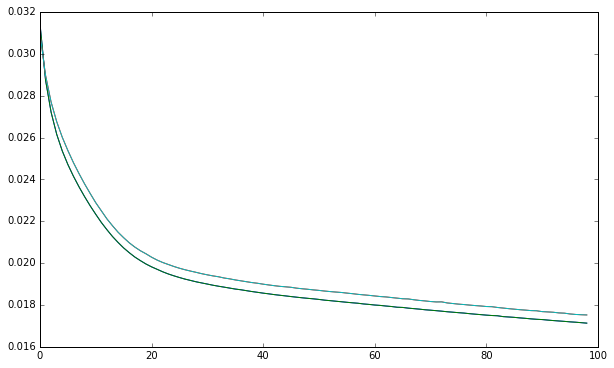

In [10]:
plt.plot(errors[1:100,])

In [12]:
e=dict()
e['train_L1_R0']=[]

In [15]:
e['train_L1_R0'].append(4)

In [16]:
e

{'train_L1_R0': [3, 4]}

/Users/jgdwyer/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


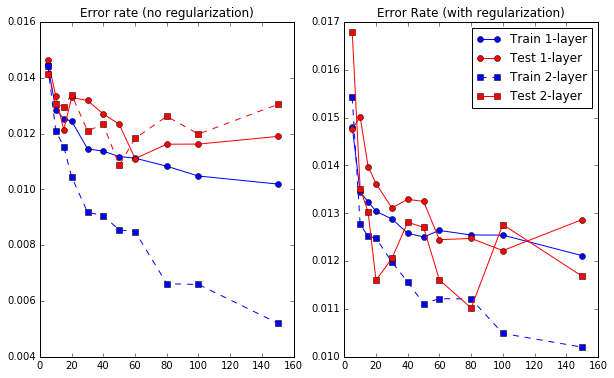

In [60]:
reload(nnplot)
nnplot.meta_compare_error_rate()

In [28]:
e['foo']='hey'

In [37]:
e.

dict_items([('train_L1_R0', [3, 4]), ('foo', 'hey')])

In [94]:
reload(nnplot)
nnplot.plot_all_figs('X-StandardScaler-qTindi_Y-SimpleY-qTindi_r_60R_60R_mom0.9reg1e-05')


/Users/jgdwyer/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


There is some amount of rain 59.7% of the time
There is a rate of >3 mm/day 22.1% of the time
There is convection 85.1% of the time
[15.0, 10.0]
<class 'list'>
